# ARM - GD - Data Preprocessing and Model Training

This script runs the Google dataset from the Kaggle competition.
- https://www.kaggle.com/competitions/asl-signs

It will do the following tasks:
- Load the landmarks.
- Preprocess the landmarks.
- ~~Select the best architecture and tune the hyperparameters.~~
- Train the final model.

Created by:
- Marcus Vinicius da Silva Fernandes.

2023-07-24.

ARM = Action Recognition Modelling.
GD = Google Dataset.

References:
- https://www.kaggle.com/code/jessevanderlinden/basic-lstm-and-transformer-implementation
- https://www.kaggle.com/code/jvthunder/lstm-baseline-for-starters-sign-language
- https://www.kaggle.com/code/hoyso48/1st-place-solution-training
- https://www.kaggle.com/competitions/asl-signs/discussion/406306
- https://www.youtube.com/watch?v=doDUihpj6ro

## Importing the libraries for data preprocessing

In [5]:
import numpy as np
import pandas as pd
import json
import os
import csv
from tqdm import tqdm

## Loading the data

### Accessing the landmarks
- Set up the paths of folders to locate the landmarks and the list (csv file) that associates the name of the video to the corresponding word in English.
- Creation of a dictionary to associate the words to a unique number.

In [6]:
landmarks_path = '/kaggle/input/asl-sign-language/'

In [7]:
# Opening the file train.csv to load the association of sequence ids to words
train_csv = pd.read_csv(landmarks_path + 'train.csv')

In [8]:
# Loading the json file adn creation of dictionary to associate the words to a unique number
with open(landmarks_path + 'sign_to_prediction_index_map.json', 'r') as j:
     sign_dict = json.loads(j.read())

del j

### Loading and shaping the landmarks to the desired number of frames

#### Desired number of frames
- Each video will be reshaped to have the number of rows (or frames) equal to the desired number of frames defined below.

In [9]:
NUM_FRAMES = 30

#### Landmark points to keep
- The objective is to reduce the number of features.
- All the landmarks from the hands will be kept.

In [10]:
face_keep_points = [0, 267, 269, 270, 409, 291, 375, 321, 405, 314, 17, 84, 181, 91, 146, 61, 185, 40, 39, 37]
face_keep_points.sort()
left_hand_keep_points = [i for i in range(21)]
pose_keep_points = [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 23, 24]
right_hand_keep_points = [i for i in range(21)]

face_keep_idx = [face_keep_points[i] for i in range(len(face_keep_points))]
left_hand_keep_idx = [i + 468 for i in left_hand_keep_points]
pose_keep_idx = [i + 468 + 21 for i in pose_keep_points]
right_hand_keep_idx = [i + 468 + 21 + 33 for i in right_hand_keep_points]

landmarks_to_keep = face_keep_idx + left_hand_keep_idx + pose_keep_idx + right_hand_keep_idx

del face_keep_points, left_hand_keep_points, pose_keep_points, right_hand_keep_points
del face_keep_idx, left_hand_keep_idx, pose_keep_idx, right_hand_keep_idx

In [11]:
TOTAL_ROWS = 543
desired_num_rows = len(landmarks_to_keep) * 2

#### Loading all the landmarks
- The 'z' coordinate will be dropped because, according to Google, it “should be discarded as currently the model is not fully trained to predict depth”.

In [12]:
def load_landmarks():
    # Getting the files to load
    file = landmarks_path + train_csv['path'].values#[:2000]
    word = train_csv['sign'].values#[:2000]

    # Columns to upload
    data_columns = ['x', 'y']

    landmarks = np.empty((file.shape[0], NUM_FRAMES, desired_num_rows), dtype=float)
    labels = []
    
    for i in tqdm(range(file.shape[0])):

        # Loading the file
        data = pd.read_parquet(file[i], columns=data_columns).fillna(0)
        num_frames = int(len(data) / TOTAL_ROWS)
        data = data.values.reshape(num_frames, TOTAL_ROWS, len(data_columns))
        data.astype(np.float32)

        # Dropping undesired points
        data = data[:, landmarks_to_keep]

        # Adjusting the number of frames
        if data.shape[0] > NUM_FRAMES:  # time-based sampling
            indices = np.arange(0, data.shape[0], data.shape[0] // NUM_FRAMES)[:NUM_FRAMES]
            data = data[indices]
        elif data.shape[0] < NUM_FRAMES:  # padding the videos
            rows = NUM_FRAMES - data.shape[0]
            data = np.append(np.zeros((rows, len(landmarks_to_keep), len(data_columns))), data, axis=0)

        # Reshaping the data
        landmarks[i] = data.reshape(NUM_FRAMES, len(landmarks_to_keep) * len(data_columns), order='F')
        del data

        # Creating the labels dataset
        labels.append(sign_dict[word[i]])
    return landmarks, np.array(labels)

x_train, y_train = load_landmarks()

100%|██████████| 94477/94477 [33:05<00:00, 47.57it/s]


## Importing the libraries for modelling

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import TensorBoard
# import keras_tuner as kt

# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

## Splitting the data into train, val, and test datasets
- 90% for train, 5% for validation, and 5% for testing.

In [21]:
x_train, x_val_test, y_train, y_val_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42)


## Normalizing the x datasets

In [12]:
# # Normalizing the data
# def normalize(array):
#     return (array - np.min(array)) / (np.max(array) - np.min(array))
# x_train = normalize(x_train)
# x_val = normalize(x_val)

## One-hot encoding the y datasets

In [13]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_val = label_binarizer.transform(y_val)

del label_binarizer

In [14]:
y_test.shape

(85029, 250)

In [22]:
x_test.shape

(4724, 30, 158)

## Model build

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, Activation, Dropout, LSTM, Input

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Dense(256)(inputs)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(128)(x)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(256)(x)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    lstm_output = LSTM(256)(x)

    outputs = Dense(num_classes, activation='softmax')(lstm_output)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Assuming input_shape is (None, 246) and num_classes is 250
input_shape = (None, 158)
num_classes = 250
model = build_model(input_shape, num_classes)

model.summary()


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 158)]       0         
                                                                 
 dense (Dense)               (None, None, 256)         40704     
                                                                 
 layer_normalization (LayerN  (None, None, 256)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 256)         0         
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 dense_1 (Dense)             (None, None, 128)         32896     
                                                             

## Model train

In [19]:
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
2658/2658 [==============================] - 33s 9ms/step - loss: 5.5153 - accuracy: 0.0042 - val_loss: 5.3387 - val_accuracy: 0.0116
Epoch 2/50
2658/2658 [==============================] - 25s 9ms/step - loss: 5.0089 - accuracy: 0.0264 - val_loss: 4.8885 - val_accuracy: 0.0360
Epoch 3/50
2658/2658 [==============================] - 24s 9ms/step - loss: 4.4964 - accuracy: 0.0687 - val_loss: 4.2061 - val_accuracy: 0.0953
Epoch 4/50
2658/2658 [==============================] - 24s 9ms/step - loss: 4.1780 - accuracy: 0.1058 - val_loss: 4.0035 - val_accuracy: 0.1348
Epoch 5/50
2658/2658 [==============================] - 24s 9ms/step - loss: 3.9631 - accuracy: 0.1363 - val_loss: 3.8076 - val_accuracy: 0.1624
Epoch 6/50
2658/2658 [==============================] - 24s 9ms/step - loss: 3.7604 - accuracy: 0.1662 - val_loss: 3.5360 - val_accuracy: 0.2047
Epoch 7/50
2658/2658 [==============================] - 25s 9ms/step - loss: 3.4217 - accuracy: 0.2177 - val_loss: 3.1318 - val_ac

## Visualizing the results

In [20]:
#Accessing the training and validation accuracy values
#train_accuracy = history.history['accuracy']
#val_accuracy = history.history['val_accuracy']
#train_loss = history.history['loss']
#val_loss = history.history['val_loss']

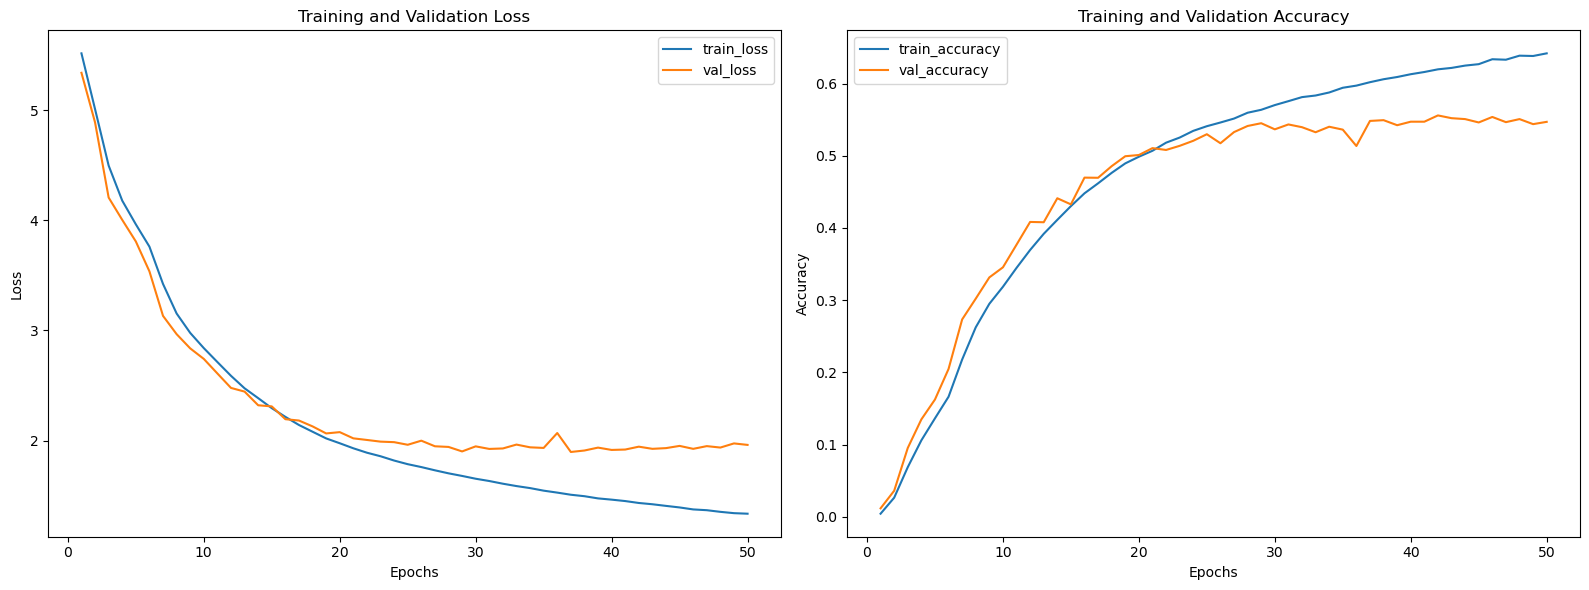

In [21]:
#import matplotlib.pyplot as plt
#%matplotlib inline

#x = [i for i in range (1, len(train_accuracy) + 1)]

# Create two subplots side by side
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting the lines on the first subplot
#ax1.plot(x, train_loss, label='train_loss')
#ax1.plot(x, val_loss, label='val_loss')
#ax1.set_xlabel('Epochs')
#ax1.set_ylabel('Loss')
#ax1.set_title('Training and Validation Loss')
#ax1.legend()

# Plotting the lines on the second subplot
#ax2.plot(x, train_accuracy, label='train_accuracy')
#ax2.plot(x, val_accuracy, label='val_accuracy')
#ax2.set_xlabel('Epochs')
#ax2.set_ylabel('Accuracy')
#ax2.set_title('Training and Validation Accuracy')
#ax2.legend()

# Adjust the layout to avoid overlapping titles and labels
#plt.tight_layout()

# Display the plots
#plt.show()

## Save the model

In [17]:
# Save the trained model to an h5 file
model.save("07-25_ARM_GD_baseline.h5")

In [24]:
import numpy as np

def predict_and_evaluate(model, x_test, y_test, sign_dict):
    # Get the predictions
    y_pred_probabilities = model.predict(x_test)

    # Convert probabilities to predicted word indices
    y_pred_indices = np.argmax(y_pred_probabilities, axis=1)

    # Create a list with the predicted words using the sign_dict
    y_pred_words = [list(sign_dict.keys())[list(sign_dict.values()).index(idx)] for idx in y_pred_indices]

    # Calculate the accuracy
    correct_predictions = np.sum(y_pred_indices == y_test)
    total_predictions = len(y_test)
    accuracy = correct_predictions / total_predictions

    return y_pred_words, accuracy

# Assuming you have already prepared your x_test and y_test datasets
# and you have defined the sign_dict

# Load the weights from the h5 file
weights_path = '07-25_ARM_GD_baseline.h5'
model.load_weights(weights_path)

# Make predictions and calculate accuracy
y_pred_words, accuracy = predict_and_evaluate(model, x_test, y_test, sign_dict)

print("Predicted words:", y_pred_words)
print("Accuracy:", accuracy)


148/148 [==============================] - 5s 36ms/step
Predicted words: ['frog', 'hate', 'frog', 'frog', 'frog', 'hate', 'frog', 'frog', 'refrigerator', 'frog', 'frog', 'refrigerator', 'refrigerator', 'frog', 'frog', 'frog', 'frog', 'frog', 'frog', 'refrigerator', 'frog', 'frog', 'refrigerator', 'frog', 'hate', 'refrigerator', 'refrigerator', 'blow', 'refrigerator', 'frog', 'frog', 'refrigerator', 'refrigerator', 'frog', 'blow', 'frog', 'frog', 'frog', 'refrigerator', 'frog', 'frog', 'refrigerator', 'frog', 'frog', 'frog', 'refrigerator', 'frog', 'frog', 'refrigerator', 'frog', 'frog', 'frog', 'frog', 'frog', 'frog', 'frog', 'refrigerator', 'frog', 'frog', 'frog', 'frog', 'refrigerator', 'frog', 'frog', 'frog', 'frog', 'frog', 'frog', 'frog', 'frog', 'frog', 'frog', 'frog', 'refrigerator', 'refrigerator', 'refrigerator', 'frog', 'frog', 'refrigerator', 'frog', 'refrigerator', 'refrigerator', 'refrigerator', 'frog', 'blow', 'hate', 'frog', 'frog', 'frog', 'frog', 'frog', 'blow', 'refri